## 첫 번째 모델링 : 근로기간 Unknown 값을 제외한 모델링

In [2]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

train = pd.read_csv('./train_new.csv')

In [3]:
train.drop('ID', axis=1, inplace=True)

1. train, test 데이터의 근로기간 수치형 변수로 수동 변환 (명시적 확인)

In [4]:
duration=dict({'10+ years':10,
 '9 years':9,
 '8 years':8,
 '7 years':7,
 '6 years':6,
 '5 years':5,
 '4 years':4,
 '3 years':3,
 '2 years':2,
 '1 year':1,
 '< 1 year':0})

train['근로기간'] = train['근로기간'].replace(duration)

train['근로기간'].value_counts()

근로기간
10    32480
2      8450
0      8144
3      7670
1      6305
5      5665
4      5588
8      4888
6      3874
7      3814
9      3744
Name: count, dtype: int64

2. 나머지 범주형 변수 (주택소유상태, 대출목적) 라벨인코더로 변환 (타깃데이터 대출등급 포함)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train['주택소유상태'] = le.fit_transform(train['주택소유상태'])
train['대출목적'] = le.fit_transform(train['대출목적'])
train['대출등급'] = le.fit_transform(train['대출등급'])

3. 데이터 분리 및 스케일러 적용 (Standard)

In [6]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_ss = ss.fit_transform(X)

4. 훈련/테스트 데이터 분리 후 모델링 진행

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_ss, y, test_size=0.3, stratify=y, random_state=42)

### 첫번째 모델 : StandardScaler 적용

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score

그리드서치를 위한 함수 제작

In [9]:
def grid_search(model, params, random=False):
    clf = model
    if not random:
        grid = GridSearchCV(clf, params,
                                scoring='f1_macro', cv=5,
                                n_jobs=-1)
    else:
        grid = RandomizedSearchCV(clf, params, n_iter=10,
                                scoring='f1_macro', cv=5,
                                n_jobs=-1, random_state=42)
        
    grid.fit(X_train, y_train)
    
    
    best_model = grid.best_estimator_
    
    best_params = grid.best_params_
    print("최상의 매개변수:", best_params)
    
    best_score = grid.best_score_
    print("훈련 점수: {:.3f}".format(best_score))
    
    y_pred = best_model.predict(X_val)
    macro_f1_val = f1_score(y_val, y_pred, average='macro')
    print('테스트 세트 점수: {:.3f}'.format(macro_f1_val))

① DecisionTreeClassifier 하이퍼파라미터 튜닝

In [53]:
params = {'min_samples_leaf':[18,19,20,21,22],
          'min_impurity_decrease':[0.0],
          'max_features':['auto',0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70],
          'max_depth':[None,11,12,13,14,15,16,17,18],
          'class_weight' : [None, 'balanced']}

grid_search(DecisionTreeClassifier(random_state=42), params, random=True)

최상의 매개변수: {'min_samples_leaf': 18, 'min_impurity_decrease': 0.0, 'max_features': 0.65, 'max_depth': 15, 'class_weight': None}
훈련 점수: 0.649
테스트 세트 점수: 0.645


최상의 매개변수: {min_samples_leaf=20, min_impurity_decrease= 0, max_features=0.6,
                                 max_depth=14, class_weight='balanced'}
훈련 점수: 0.512
테스트 세트 점수: 0.513

최상의 매개변수: {'min_samples_leaf': 19, 'min_impurity_decrease': 0.0, 'max_features': 0.65, 'max_depth': None, 'class_weight': None}
훈련 점수: 0.653
테스트 세트 점수: 0.644

최상의 매개변수: {'min_samples_leaf': 18, 'min_impurity_decrease': 0.0, 'max_features': 0.65, 'max_depth': 15, 'class_weight': None}
훈련 점수: 0.649
테스트 세트 점수: 0.645

3번 정도 해보니 성능 고정됨, 마지막 파라미터로 적용

② RandomForestClassifier 하이퍼파라미터 튜닝

In [14]:
params = {'min_samples_leaf':[6],
          'max_features':[0.7],
          'max_depth':[16],
          'n_estimators' : [500]}

grid_search(RandomForestClassifier(n_jobs=-1, random_state=42), params)

최상의 매개변수: {'max_depth': 16, 'max_features': 0.7, 'min_samples_leaf': 6, 'n_estimators': 500}
훈련 점수: 0.776
테스트 세트 점수: 0.780


33분 소요

최상의 매개변수: {n_estimators=500, min_samples_leaf=6, min_impurity_decrease=0, 
                                 max_features=0.7, max_depth=16}
훈련 점수: 0.655
테스트 세트 점수: 0.657

38분 소요

최상의 매개변수: {'n_estimators': 800, 'min_samples_leaf': 15, 'min_impurity_decrease': 0.0, 'max_features': 0.6, 'max_depth': 90}
훈련 점수: 0.689
테스트 세트 점수: 0.706

44분 소요

최상의 매개변수: {'n_estimators': 800, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_features': 0.7, 'max_depth': 95}
훈련 점수: 0.785
테스트 세트 점수: 0.789


66분 소요

최상의 매개변수: {'n_estimators': 810, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0, 'max_features': 0.73, 'max_depth': 95}
훈련 점수: 0.795
테스트 세트 점수: 0.802

③ XGBClassifier 하이퍼파라미터 튜닝

In [12]:
params = {'n_estimators' : [100,200,300,350,400,450,500,1000],
          'learning_rate' : [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
          'max_depth' : [10,30,35,40,45,50,100,200],
          'objective' : ['multi:softmax']}

grid_search(XGBClassifier(random_state=42, n_jobs=-1), params, random=True)

최상의 매개변수: {'objective': 'multi:softmax', 'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1}
훈련 점수: 0.787
테스트 세트 점수: 0.789


n_estimators=400, max_depth=40, learning_rate=0.05
훈련 점수: 0.792
테스트 세트 점수: 0.789

25분 소요 - 성능차이 크게 안남, 이거 적용하면 될 듯

최상의 매개변수: {'objective': 'multi:softmax', 'n_estimators': 350, 'max_depth': 35, 'learning_rate': 0.06}
훈련 점수: 0.787
테스트 세트 점수: 0.789

④ LGBMClassifier 하이퍼파라미터 튜닝

In [11]:
params = {'n_estimators' : [100,300,500],
          'learning_rate' : [0.01,0.1,0.2],
          'max_depth' : [50,100,150],
          'num_leaves' : [5,10,15,20,25]}

grid_search(LGBMClassifier(objective='multiclass', random_state=42, n_jobs=-1), params, random=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1455
[LightGBM] [Info] Number of data points in the train set: 63435, number of used features: 13
[LightGBM] [Info] Start training from score -1.744243
[LightGBM] [Info] Start training from score -1.208106
[LightGBM] [Info] Start training from score -1.248814
[LightGBM] [Info] Start training from score -1.982449
[LightGBM] [Info] Start training from score -2.564256
[LightGBM] [Info] Start training from score -3.885346
[LightGBM] [Info] Start training from score -5.433754
최상의 매개변수: {'num_leaves': 15, 'n_estimators': 300, 'max_depth': 100, 'learning_rate': 0.1}
훈련 점수: 0.765
테스트 세트 점수: 0.756


최상의 매개변수: {'num_leaves': 15, 'n_estimators': 300, 'max_depth': 100, 'learning_rate': 0.1}
훈련 점수: 0.765
테스트 세트 점수: 0.756

16분 소요

최상의 매개변수: {'num_leaves': 25, 'n_estimators': 500, 'max_depth': 100, 'learning_rate': 0.1}
훈련 점수: 0.781
테스트 세트 점수: 0.772

15분 소요

최상의 매개변수: {'num_leaves': 40, 'n_estimators': 1500, 'max_depth': 130, 'learning_rate': 0.025}
훈련 점수: 0.783
테스트 세트 점수: 0.781

38분 소요 - 성능향상 크게없으니 이 결과 사용

최상의 매개변수: {'num_leaves': 41, 'n_estimators': 1500, 'max_depth': 130, 'learning_rate': 0.024}
훈련 점수: 0.786
테스트 세트 점수: 0.786

### StratifiedKFold를 이용한 스코어 산정

In [15]:
X_ss = pd.DataFrame(X_ss, columns=X.columns)

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_macro_scores = []

def skf_score(model):
    for train_idx, valid_idx in skf.split(X_ss, y):
        X_train = X_ss.iloc[train_idx]
        X_val = y.iloc[train_idx]

        y_train = X_ss.iloc[valid_idx]
        y_val = y.iloc[valid_idx]

        model.fit(X_train, X_val)

        pred = model.predict(y_train)

        f1_macro = f1_score(y_val, pred, average='macro')
        f1_macro_scores.append(f1_macro)
    
    average_f1_macro = np.mean(f1_macro_scores)

    print("Average F1-macro score:", average_f1_macro)
    try:
        if model.feature_importances_.any():
            feature_importances = model.feature_importances_
            print("\n",'-'*10,'특성중요도','-'*10)
            for feature, importance in zip(X_ss.columns, feature_importances):
                print(f"{feature}: {importance}")
    except:
        None

위에서 뽑은 파라미터로 적용

In [16]:
skf_score(DecisionTreeClassifier(min_samples_leaf=18, min_impurity_decrease=0, max_features=0.65,
                                 max_depth=None, class_weight=None, random_state=42))

Average F1-macro score: 0.6968422098285477

 ---------- 특성중요도 ----------
대출금액: 0.04900712233919834
대출기간: 0.048539654020564635
근로기간: 0.0024250355877461307
주택소유상태: 0.0013768127792064082
연간소득: 0.01028499357994517
부채_대비_소득_비율: 0.0150077983857236
총계좌수: 0.004278178175630344
대출목적: 0.0025832237981494852
최근_2년간_연체_횟수: 0.0006171864580104605
총상환원금: 0.5270665411603973
총상환이자: 0.33881345371542804
총연체금액: 0.0
연체계좌수: 0.0


In [17]:
skf_score(RandomForestClassifier(n_estimators=500, min_samples_leaf=6, min_impurity_decrease=0, 
                                 max_features=0.7, max_depth=16, random_state=42, n_jobs=-1))

Average F1-macro score: 0.7485917702360808

 ---------- 특성중요도 ----------
대출금액: 0.053527667100098895
대출기간: 0.04263766293921377
근로기간: 0.004756096721114878
주택소유상태: 0.002095813620657235
연간소득: 0.01921181149214468
부채_대비_소득_비율: 0.013432040026271602
총계좌수: 0.008402935426696942
대출목적: 0.0037389216298644493
최근_2년간_연체_횟수: 0.001554973350043199
총상환원금: 0.45235615901103005
총상환이자: 0.39828382733382034
총연체금액: 1.6984222548462489e-07
연체계좌수: 1.9215068184622815e-06


In [18]:
skf_score(XGBClassifier(objective='multi:softmax', n_estimators=100, max_depth=30, 
          learning_rate=0.1, n_jobs=-1, random_state=42))

Average F1-macro score: 0.7684275857991395

 ---------- 특성중요도 ----------
대출금액: 0.020793480798602104
대출기간: 0.652576208114624
근로기간: 0.00926718395203352
주택소유상태: 0.009506371803581715
연간소득: 0.013877324759960175
부채_대비_소득_비율: 0.010072682052850723
총계좌수: 0.009768208488821983
대출목적: 0.012159624136984348
최근_2년간_연체_횟수: 0.010992753319442272
총상환원금: 0.10836970061063766
총상환이자: 0.11888863146305084
총연체금액: 0.01491092424839735
연체계좌수: 0.00881692674010992


앞선 두 트리의 결과는 총상환원금과 총상환이자의 중요도가 매우 큰데 반해 XGB에서는 대출기간의 중요도가 가장 높게 나왔다. 

다음으로 총상환원금과 총상환이자가 높다 -> 이 부분 유념하여 체크

In [19]:
skf_score(LGBMClassifier(objective='multiclass', num_leaves=15, n_estimators=300, max_depth=100, 
               learning_rate=0.1, n_jobs=-1, random_state=42))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 81559, number of used features: 13
[LightGBM] [Info] Start training from score -1.744289
[LightGBM] [Info] Start training from score -1.208056
[LightGBM] [Info] Start training from score -1.248847
[LightGBM] [Info] Start training from score -1.982382
[LightGBM] [Info] Start training from score -2.564275
[LightGBM] [Info] Start training from score -3.885514
[LightGBM] [Info] Start training from score -5.434151
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1466
[LightGBM

LGBM에서의 특성 중요도는 총상환원금, 총상환이자, 대출금액 순으로 중요도가 크게 나타났다.

model|k-Fold|Sk-Fold
-|-|-
DecisionTree Classifier|0.645|0.6968422098285477
RandomForest Classifier|0.780|0.7485917702360808
XGBoost Classifier|0.789|0.7684275857991395 --> 최고 성능
Light GBM Classifier|0.772|0.7663219576828357

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import set_matplotlib_hangul

train = pd.read_csv('./train.csv')

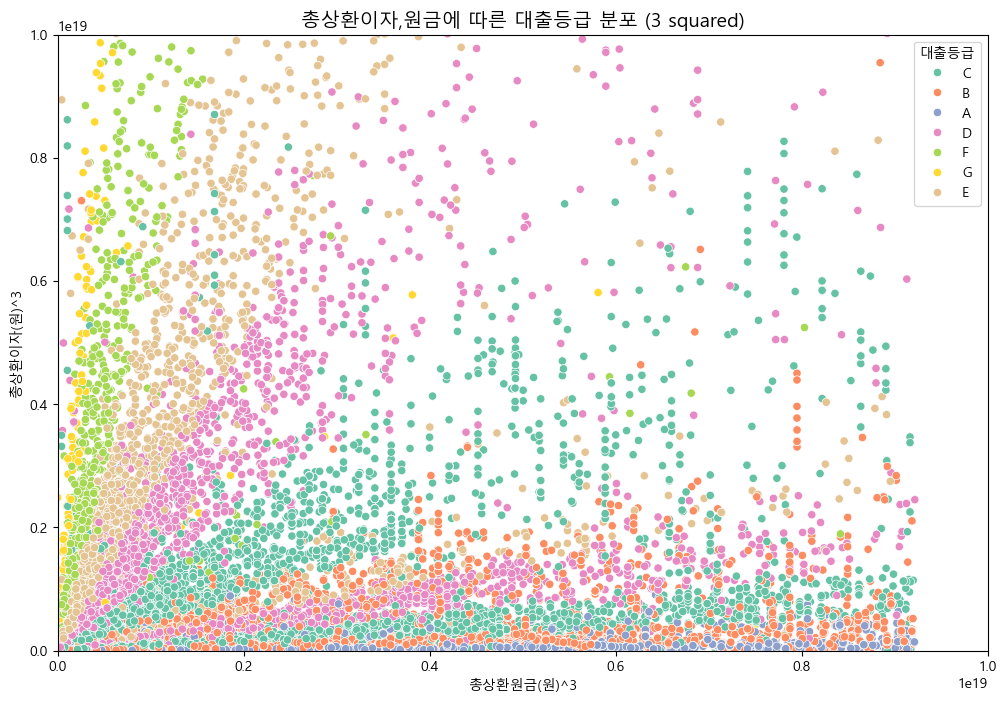

In [83]:
train['총상환이자'] = train['총상환이자'] ** 3 
train['총상환원금'] = train['총상환원금'] ** 3

plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='총상환원금', y='총상환이자', hue='대출등급', palette='Set2')
plt.ylim(0,10**19)
plt.xlim(0,10**19)
plt.xlabel('총상환원금(원)^3')
plt.ylabel('총상환이자(원)^3')
plt.title('총상환이자,원금에 따른 대출등급 분포 (3 squared)', fontsize=14)
plt.show()

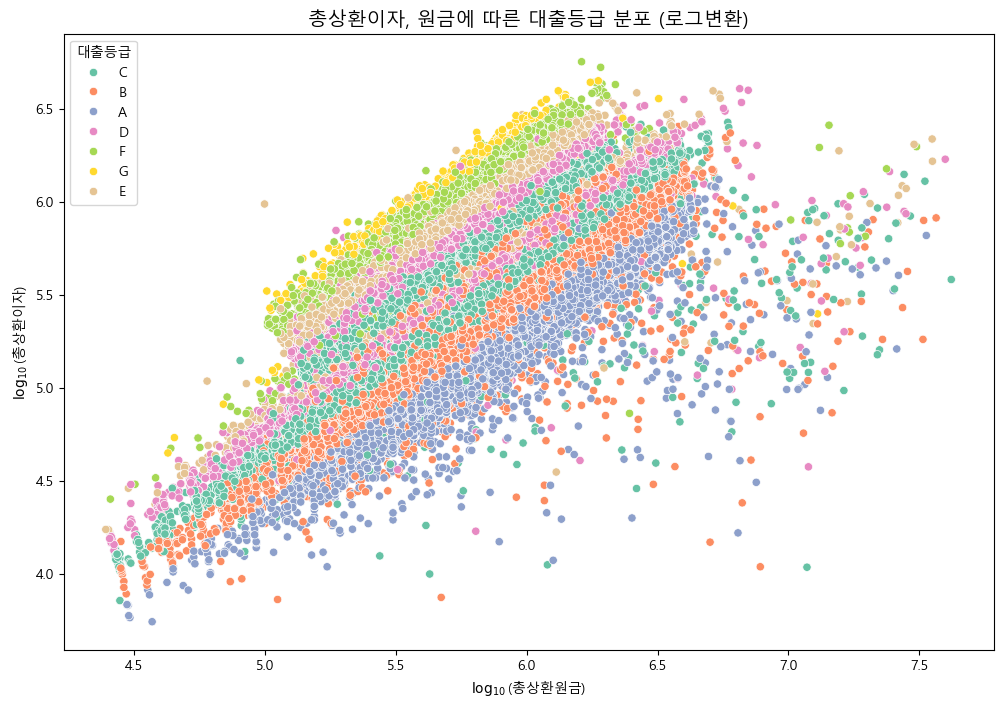

In [84]:
train = pd.read_csv('./train.csv')

train['총상환이자'] = np.log10(train['총상환이자'])
train['총상환원금'] = np.log10(train['총상환원금'])

plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='총상환원금', y='총상환이자', hue='대출등급', palette='Set2')
plt.xlabel("$\log_{10}$(총상환원금)")
plt.ylabel("$\log_{10}$(총상환이자)")
plt.title('총상환이자, 원금에 따른 대출등급 분포 (로그변환)', fontsize=14)
plt.show()

실제로 총상환이자, 원금 칼럼의 중요도를 확인하게 위해 scatterplot을 그려본 결과 대출 등급 별 군집이 명확하게 나타나는 것을 확인할 수 있음

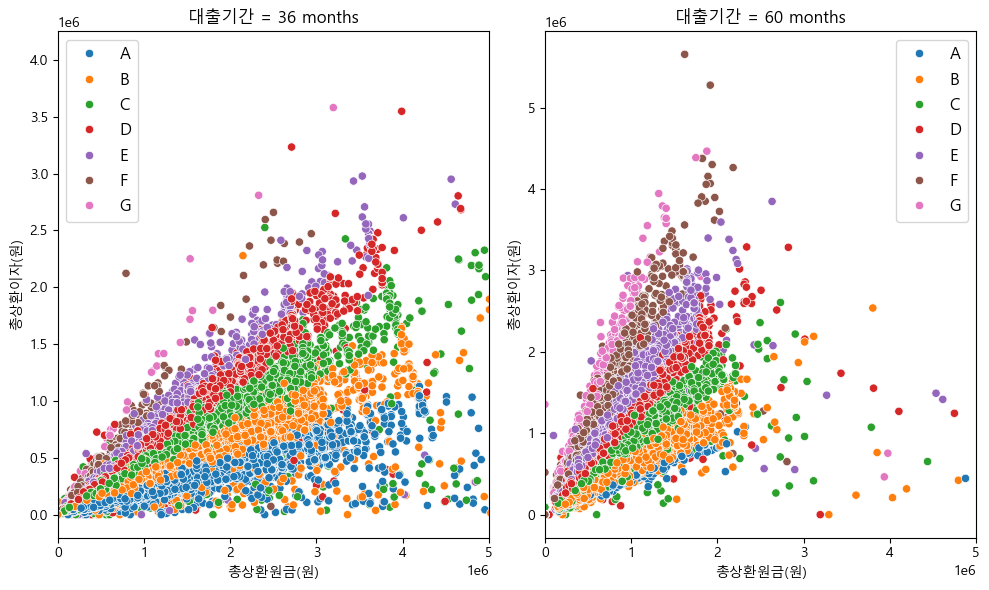

In [85]:
train = pd.read_csv('./train.csv')

grade = ['A','B','C','D','E','F','G']

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.scatterplot(x='총상환원금',y='총상환이자',hue='대출등급',data=train[train['대출기간']==' 36 months'], hue_order=grade)
plt.gca().set_title('대출기간 = 36 months')
plt.xlim(0,5*10**6)
plt.xlabel('총상환원금(원)')
plt.ylabel('총상환이자(원)')
plt.legend(fontsize=12)

plt.subplot(1,2,2)
sns.scatterplot(x='총상환원금',y='총상환이자',hue='대출등급',data=train[train['대출기간']==' 60 months'], hue_order=grade)
plt.gca().set_title('대출기간 = 60 months')
plt.xlim(0,5*10**6)
plt.xlabel('총상환원금(원)')
plt.ylabel('총상환이자(원)')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

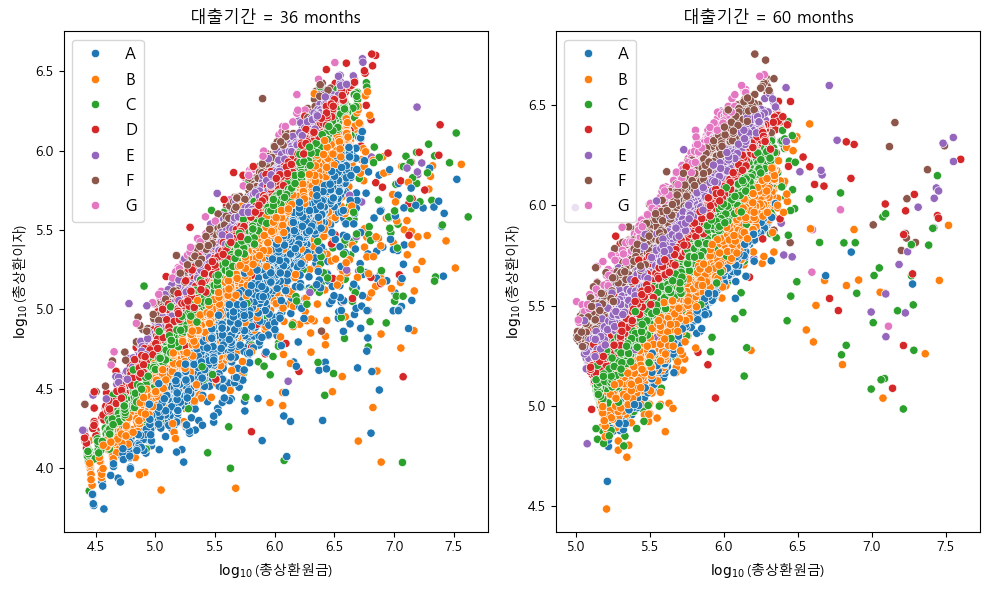

In [42]:
train = pd.read_csv('./train.csv')

train['총상환이자'] = np.log10(train['총상환이자'])
train['총상환원금'] = np.log10(train['총상환원금'])

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.scatterplot(x='총상환원금',y='총상환이자',hue='대출등급',data=train[train['대출기간']==' 36 months'], hue_order=grade)
plt.gca().set_title('대출기간 = 36 months')
plt.xlabel("$\log_{10}$(총상환원금)")
plt.ylabel("$\log_{10}$(총상환이자)")
plt.legend(fontsize=12)

plt.subplot(1,2,2)
sns.scatterplot(x='총상환원금',y='총상환이자',hue='대출등급',data=train[train['대출기간']==' 60 months'], hue_order=grade)
plt.gca().set_title('대출기간 = 60 months')
plt.xlabel("$\log_{10}$(총상환원금)")
plt.ylabel("$\log_{10}$(총상환이자)")
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()